In [24]:
from __future__ import print_function

import math
from IPython.core import display as ICD
from matplotlib  import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

import tensorflow as tf
import tensorflow.python.data as tf_data
from tensorflow.keras import optimizers
tf.compat.v1.disable_eager_execution()

# Predicción de los precios de la vivienda con regresión lineal 
 **Aprendizaje automático desde cero (Parte II)**

In [25]:
# Paso 1: cargamos el data frame
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
california_housing_dataframe =  pd.read_csv("C:/Users/Usuario/Archivos en Jupyter/Tensorflow/input/housing.csv", sep=",")

In [26]:
# Paso 2: separamos los datos de entrenamiento y prueba
myfeature =california_housing_dataframe[["total_rooms"]]
feature_columns = [tf.feature_column.numeric_column("total_rooms")] 
targets = california_housing_dataframe["median_house_value"]

In [27]:
# Paso 3: definimos el optimizador
my_optimizer = optimizers.SGD(learning_rate=0.0000001, clipnorm=5.0)

In [28]:
# Paso 4: definimos el modelo de regresión
linear_regresor =tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

In [29]:
# Paso 5: definimos la función input
#Input , devuelven la forma del tensor en el tiempo de construcción, que puede ser parcialmente desconocida.

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Entrena un modelo de regresión lineal.
  
    Argumentos:
      features: pandas DataFrame de características
      target: pandas DataFrame de objetivos
      batch_size: Tamaño de los lotes a pasar al modelo
      shuffle: Verdadero o Falso. Ya sea para mezclar los datos.
      num_epochs: Número de épocas para las que se deben repetir los datos. Ninguno = repetir indefinidamente
    Devoluciones:
      Tupla de (características, etiquetas) para el siguiente lote de datos
    """
  
    # Convierta los datos de pandas en un diccionario de matrices np.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = tf.compat.v1.data.Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [30]:
# Paso 6: entrenar el modelo

# _ Almacenar el valor de la última expresión en intérprete.
_ = linear_regresor.train(
    input_fn = lambda:my_input_fn(myfeature, targets), # Lambda  son una forma corta de declarar funciones pequeñas y anónimas
    steps=100
)

c:\Users\Usuario\anaconda3\lib\site-packages\keras\engine\base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [31]:
# Paso 7: Evaluar el modelo

# crear una función input para prediccciones
# Nota: como solo se va a hacer una predicción para cada ejemplo
# no tenemos que repetir o mezclar los datops aqui

prediction_input_fn =lambda: my_input_fn(myfeature, targets, num_epochs=1, shuffle=False)

# llamar a predict() en el linear_regresor para hacer las predicciones
predictions = linear_regresor.predict(input_fn=prediction_input_fn)

# Formateamos las predicciones como un array np para que podamos calcular las métricas de error
predictions = np.array([item['predictions'][0] for item in predictions])

# imprimimos el error cuadrático medio y raiz error cuadratico medio
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Error cuadrático medio (MSE) en datos de entrenamiento: %0.3f" % mean_squared_error)
print("Raíz del error cuadrático medio (RMSE) en datos de entrenamiento: %0.3f" % root_mean_squared_error)

Error cuadrático medio (MSE) en datos de entrenamiento: 56104774069.783
Raíz del error cuadrático medio (RMSE) en datos de entrenamiento: 236864.464


In [32]:
# Comparamos el RMSE con min y max de nuestros targets

min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Minimo valor de casa: %0.3f" % min_house_value)
print("Maximo valor de casa: %0.3f" % max_house_value)
print("Diferencia entre el maximo y el minimo: %0.3f" % min_max_difference)
print("La diferencia entre el maximo y el minimo es: %0.3f" % root_mean_squared_error)

Minimo valor de casa: 14999.000
Maximo valor de casa: 500001.000
Diferencia entre el maximo y el minimo: 485002.000
La diferencia entre el maximo y el minimo es: 236864.464


# Creación de gráficas

In [53]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
0,0.0,452600.0
1,0.4,358500.0
2,0.1,352100.0
3,0.1,341300.0
4,0.1,342200.0


In [55]:
sample=california_housing_dataframe.sample(n=300)


In [56]:
#Obtenemos los valores minimo y máximo de total_rooms
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()


In [57]:
#Recuperamos el peso y el sesgo final generado durante el entrenamiento
weight = linear_regresor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regresor.get_variable_value('linear/linear_model/bias_weights')

In [58]:
#Obtener los median_house_values predichos para los valores min y max total_rooms
# Tener en cuenta la fórmula de la regresión y=mx +b
y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

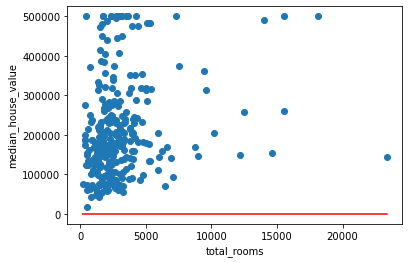

In [61]:

# Trazamos una linea de regresión desde (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Nombramos los ejes del grafico.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

#Trazamos una gráfica de dispersión de nuestros datos de ejemplo
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()